## Libraries to import

In [1]:
!pip install tensorflow
!pip install -q -U keras-tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.4/129.4 kB 4.5 MB/s eta 0:00:00


In [2]:
from google.colab import drive
drive.mount('/content/drive')
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras
import keras_tuner as kt

Mounted at /content/drive


## Importing the dataset

In [22]:
all_prices = pd.read_csv('/content/drive/MyDrive/ml-datasets/currencies_prediction/prices_30m.csv')

### Feature engineering

In [23]:
# adding features that make more sense than raw data
# all_prices["Gold_ret"] = all_prices["Gold"].pct_change()
# all_prices["Silver_ret"] = all_prices["Silver"].pct_change()
# all_prices["CAD_ret"] = all_prices["CAD"].pct_change()

# all_prices["Gold_ma"] = all_prices["Gold"].rolling(5).mean()
# all_prices["Silver_ma"] = all_prices["Silver"].rolling(5).mean()
# all_prices["CAD_ma"] = all_prices["CAD"].rolling(5).mean()

In [24]:
all_prices = all_prices.dropna().drop(columns=['Datetime'])

In [25]:
all_prices.head()

,Gold,Silver,CAD
0,3958.5,48.395,0.716220
1,3958.5,48.395,0.716117
2,3958.5,48.395,0.716184
3,3958.5,48.395,0.716522
4,3958.5,48.395,0.716384


In [26]:
all_prices.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1973 entries, 0 to 1972
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Gold    1973 non-null   float64
 1   Silver  1973 non-null   float64
 2   CAD     1973 non-null   float64
dtypes: float64(3)
memory usage: 46.4 KB


In [27]:
all_prices.describe()

,Gold,Silver,CAD
count,1973.000000,1973.000000,1973.000000
mean,4102.678971,50.063748,0.713069
std,102.338747,2.476129,0.002467
min,3912.000000,45.665001,0.707269
25%,4015.300049,48.180000,0.711739
50%,4084.000000,49.654999,0.713079
75%,4177.700195,51.310001,0.714643
max,4394.299805,59.195000,0.719746


In [28]:
scaler = MinMaxScaler()
scaled = scaler.fit_transform(all_prices)
scaled

array([[0.09641306, 0.20177382, 0.71740044],
       [0.09641306, 0.20177382, 0.70917412],
       [0.09641306, 0.20177382, 0.7145198 ],
       ...,
       [0.6960405 , 0.90059118, 0.57467706],
       [0.69583295, 0.89504817, 0.57467706],
       [0.69894305, 0.89911323, 0.57467706]])

In [29]:
def create_sequences(data, timesteps):
    X, y = [], []
    for i in range(len(data) - timesteps):
        X.append(data[i : i + timesteps])
        y.append(data[i + timesteps])
    return np.array(X), np.array(y)

In [30]:
max_window = 60

X, y = create_sequences(scaled, max_window)
X.shape

(1913, 60, 3)

### Train/test split

In [31]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, shuffle=False)

## GRU implementation

### Hyperparameter tuning

In [ ]:
def rmse(y_true, y_pred):
    return tf.sqrt(tf.reduce_mean(tf.square(y_true - y_pred)))

def mae(y_true, y_pred):
    return tf.reduce_mean(tf.abs(y_true - y_pred))

def mape(y_true, y_pred):
    return tf.reduce_mean(tf.abs((y_true - y_pred) / (y_true + 1e-8))) * 100

In [ ]:
def model_builder(hp):
    model = keras.Sequential([
        keras.layers.GRU(
            units=hp.Int("units_1", min_value=16, max_value=128, step=16),
            return_sequences=True,
            input_shape=(hp.Int("window", min_value=10, max_value=100, step=10), 3),
            kernel_regularizer=keras.regularizers.l2(hp.Choice("l2_reg", values=[1e-6, 1e-5, 1e-4]))
        ),
        keras.layers.Dropout(hp.Float("dropout_1", min_value=0.1, max_value=0.3, step=0.05)),
        keras.layers.GRU(
            units=hp.Int("units_2", min_value=8, max_value=64, step=8),
            return_sequences=False,
            kernel_regularizer=keras.regularizers.l2(hp.Choice("l2_reg2", [1e-6, 1e-5, 1e-4])),
        ),
        keras.layers.Dropout(hp.Float("dropout_2", min_value=0.1, max_value=0.3, step=0.05)),
        keras.layers.Dense(3, activation="relu") #output
    ])

    model.compile(
        optimizer=keras.optimizers.Adam(hp.Choice("learning_rate", [1e-2, 5e-3, 1e-3, 5e-4, 1e-4])),\
        loss="mse",
        metrics=[rmse, mae, mape]
    )

    return model

In [ ]:
tuner = kt.Hyperband(
    model_builder,
    objective=kt.Objective("val_rmse", direction="min"),
    max_epochs=40,
    max_consecutive_failed_trials=5,
    seed=42,
    directory="tuning_results",
    project_name="gold_silver_cad",
)

Reloading Tuner from tuning_results/gold_silver_cad/tuner0.json


In [ ]:
stop_early = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5
)

In [ ]:
tuner.search(x=X_train, y=y_train, validation_split=0.15, callbacks=[stop_early])

Trial 87 Complete [00h 02m 29s]
val_rmse: 0.05844685062766075

Best val_rmse So Far: 0.01888570375740528
Total elapsed time: 01h 44m 11s


### Metrics evaluation of the best model

In [ ]:
best_model = tuner.get_best_models(1)[0]
best_model.save('gru_30m.keras')
best_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru (GRU)                       │ (None, 80, 112)        │        39,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 80, 112)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_1 (GRU)                     │ (None, 64)             │        34,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 73,683 (287.82 KB)

 Trainable params: 73,683 (287.82 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
best_hps.values

{'units_1': 112,
 'window': 80,
 'l2_reg': 1e-05,
 'dropout_1': 0.1,
 'learning_rate': 0.005,
 'units_2': 64,
 'l2_reg2': 1e-06,
 'dropout_2': 0.25,
 'tuner/epochs': 40,
 'tuner/initial_epoch': 14,
 'tuner/bracket': 3,
 'tuner/round': 3,
 'tuner/trial_id': '0045'}

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

model = best_model

y_pred = model.predict(X_test)

y_pred_inv = scaler.inverse_transform(y_pred)
y_test_inv = scaler.inverse_transform(y_test)

rmse_val = np.sqrt(mean_squared_error(y_test_inv, y_pred_inv))
mae_val  = mean_absolute_error(y_test_inv, y_pred_inv)
mape_val = mean_absolute_percentage_error(y_test_inv, y_pred_inv)

print("RMSE:", rmse_val)
print("MAE :", mae_val)
print("MAPE:", mape_val)

9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step
RMSE: 8.361919700830407
MAE : 4.017897104637491
MAPE: 0.0028908187464457614


In [ ]:
baseline = scaler.inverse_transform(X_test[:, -1, :])

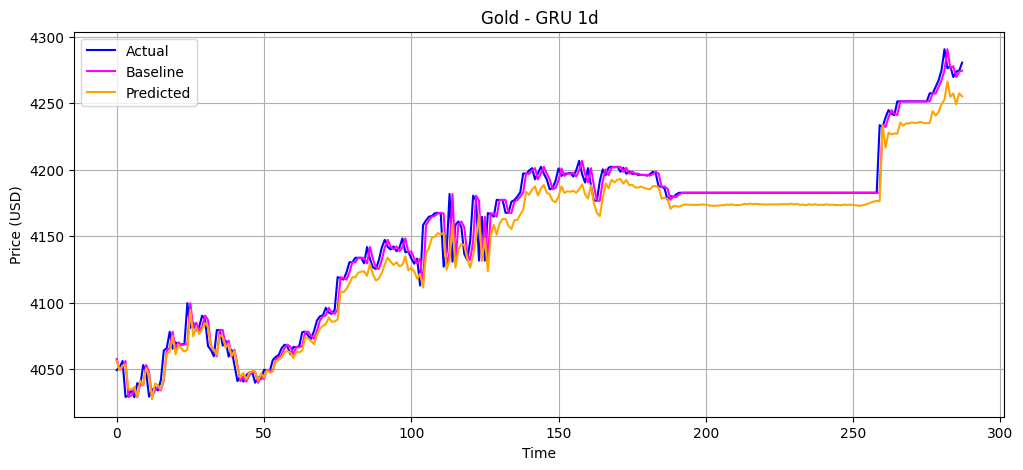

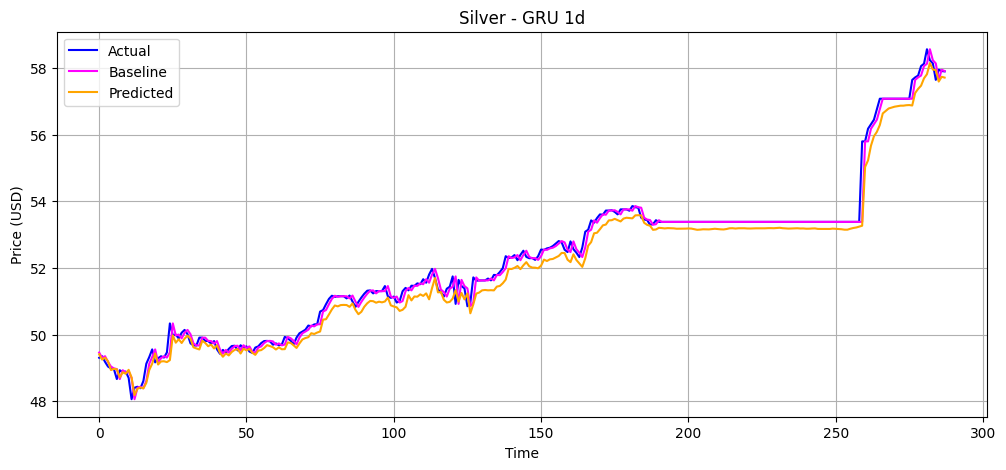

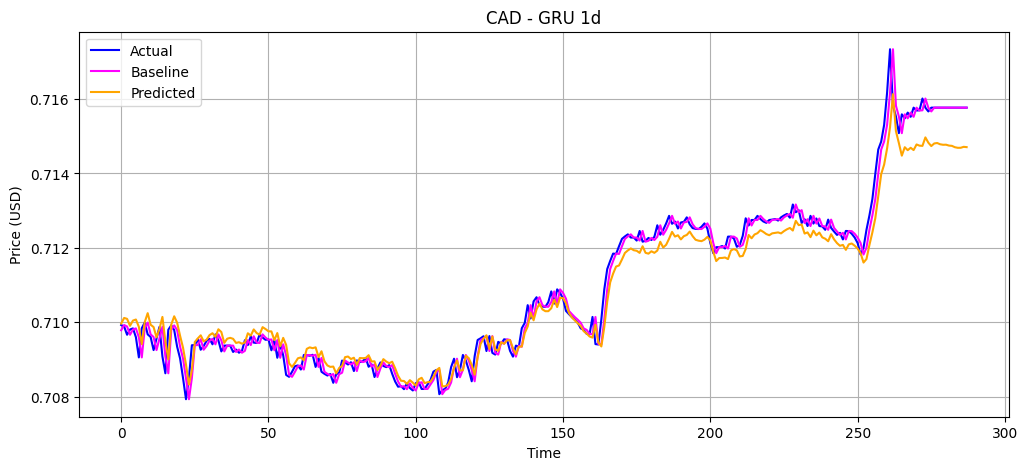

In [ ]:
def plot_asset(i, asset_name):
    plt.figure(figsize=(12,5))
    plt.plot(y_test_inv[:, i], label="Actual", color="blue")
    plt.plot(baseline[:, i], label="Baseline", color="magenta")
    plt.plot(y_pred_inv[:, i], label="Predicted", color="orange")
    plt.title(f"{asset_name} - GRU 1d")
    plt.xlabel("Time")
    plt.ylabel("Price (USD)")
    plt.legend()
    plt.grid(True)
    plt.show()

plot_asset(0, "Gold")
plot_asset(1, "Silver")
plot_asset(2, "CAD")

In [ ]:
def mae(y, p): return np.mean(np.abs(y-p))
def rmse(y, p): return np.sqrt(np.mean((y-p)**2))
def mape(y, p): return np.mean(np.abs((y-p)/y))*100

assets = ["Gold","Silver","CAD"]
for i in range(3):
    print(assets[i])
    print(" MAE :", mae(y_test_inv[:,i], y_pred_inv[:,i]))
    print(" RMSE:", rmse(y_test_inv[:,i], y_pred_inv[:,i]))
    print(" MAPE:", mape(y_test_inv[:,i], y_pred_inv[:,i]))
    print()

Gold
 MAE : 11.773379855685766
 RMSE: 14.47891649613562
 MAPE: 0.2823840385222284

Silver
 MAE : 0.27993426058027454
 RMSE: 0.35507760039680486
 MAPE: 0.5318953326281447

CAD
 MAE : 0.0003771976464324527
 RMSE: 0.0004950104778956928
 MAPE: 0.052966252783355865



### Mean + std

To ensure the model did not randomly achieve good results with the test set

In [13]:
def rmse(y_true, y_pred):
    return tf.sqrt(tf.reduce_mean(tf.square(y_true - y_pred)))

def mae(y_true, y_pred):
    return tf.reduce_mean(tf.abs(y_true - y_pred))

def mape(y_true, y_pred):
    return tf.reduce_mean(tf.abs((y_true - y_pred) / (y_true + 1e-8))) * 100

In [14]:
# {'units_1': 112,
#  'window': 80,
#  'l2_reg': 1e-05,
#  'dropout_1': 0.1,
#  'learning_rate': 0.005,
#  'units_2': 64,
#  'l2_reg2': 1e-06,
#  'dropout_2': 0.25,
#  'tuner/epochs': 40,
#  'tuner/initial_epoch': 14,
#  'tuner/bracket': 3,
#  'tuner/round': 3,
#  'tuner/trial_id': '0045'}

In [16]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

mae_arr = []
rmse_arr = []
mape_arr = []

for i in range(10):

  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, shuffle=False)

  model = keras.Sequential([
      keras.layers.GRU(
          units=112,
          return_sequences=True,
          input_shape=(80, 3),
          kernel_regularizer=keras.regularizers.l2(1e-05)
      ),
      keras.layers.Dropout(0.1),
      keras.layers.GRU(
          units=64,
          return_sequences=False,
          kernel_regularizer=keras.regularizers.l2(1e-06),
      ),
      keras.layers.Dropout(0.25),
      keras.layers.Dense(3, activation="relu") #output
  ])

  model.compile(
      optimizer=keras.optimizers.Adam(0.005),
      loss='mse',
      metrics=[rmse, mae, mape]
  )

  model.fit(X_train, y_train, epochs=40)

  y_pred = model.predict(X_test)

  y_pred_inv = scaler.inverse_transform(y_pred)
  y_test_inv = scaler.inverse_transform(y_test)

  rmse_val = np.sqrt(mean_squared_error(y_test_inv, y_pred_inv))
  mae_val  = mean_absolute_error(y_test_inv, y_pred_inv)
  mape_val = mean_absolute_percentage_error(y_test_inv, y_pred_inv)

  rmse_arr.append(rmse_val)
  mae_arr.append(mae_val)
  mape_arr.append(mape_val)

  print("RMSE:", rmse_val)
  print("MAE :", mae_val)
  print("MAPE:", mape_val)

Epoch 1/40
51/51 ━━━━━━━━━━━━━━━━━━━━ 21s 189ms/step - loss: 0.0473 - mae: 0.1453 - mape: 832336.6875 - rmse: 0.1801
Epoch 2/40
51/51 ━━━━━━━━━━━━━━━━━━━━ 9s 169ms/step - loss: 0.0035 - mae: 0.0438 - mape: 266912.9062 - rmse: 0.0572
Epoch 3/40
51/51 ━━━━━━━━━━━━━━━━━━━━ 5s 88ms/step - loss: 0.0031 - mae: 0.0415 - mape: 258850.7969 - rmse: 0.0537
Epoch 4/40
51/51 ━━━━━━━━━━━━━━━━━━━━ 9s 172ms/step - loss: 0.0027 - mae: 0.0393 - mape: 42791.2344 - rmse: 0.0505
Epoch 5/40
51/51 ━━━━━━━━━━━━━━━━━━━━ 13s 246ms/step - loss: 0.0025 - mae: 0.0371 - mape: 20548.4512 - rmse: 0.0484
Epoch 6/40
51/51 ━━━━━━━━━━━━━━━━━━━━ 7s 141ms/step - loss: 0.0023 - mae: 0.0355 - mape: 21620.9746 - rmse: 0.0467
Epoch 7/40
51/51 ━━━━━━━━━━━━━━━━━━━━ 9s 111ms/step - loss: 0.0022 - mae: 0.0343 - mape: 72622.5703 - rmse: 0.0450
Epoch 8/40
51/51 ━━━━━━━━━━━━━━━━━━━━ 9s 83ms/step - loss: 0.0016 - mae: 0.0301 - mape: 153561.2344 - rmse: 0.0393
Epoch 9/40
51/51 ━━━━━━━━━━━━━━━━━━━━ 6s 109ms/step - loss: 0.0019 - mae: 0.

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


51/51 ━━━━━━━━━━━━━━━━━━━━ 10s 114ms/step - loss: 0.0476 - mae: 0.1481 - mape: 1741232.3750 - rmse: 0.1828
Epoch 2/40
51/51 ━━━━━━━━━━━━━━━━━━━━ 4s 84ms/step - loss: 0.0038 - mae: 0.0466 - mape: 87240.9844 - rmse: 0.0598
Epoch 3/40
51/51 ━━━━━━━━━━━━━━━━━━━━ 4s 84ms/step - loss: 0.0032 - mae: 0.0429 - mape: 142107.8750 - rmse: 0.0554
Epoch 4/40
51/51 ━━━━━━━━━━━━━━━━━━━━ 6s 115ms/step - loss: 0.0027 - mae: 0.0387 - mape: 119052.4219 - rmse: 0.0507
Epoch 5/40
51/51 ━━━━━━━━━━━━━━━━━━━━ 4s 83ms/step - loss: 0.0023 - mae: 0.0352 - mape: 36021.8008 - rmse: 0.0462
Epoch 6/40
51/51 ━━━━━━━━━━━━━━━━━━━━ 5s 82ms/step - loss: 0.0026 - mae: 0.0383 - mape: 18299.1211 - rmse: 0.0497
Epoch 7/40
51/51 ━━━━━━━━━━━━━━━━━━━━ 6s 113ms/step - loss: 0.0020 - mae: 0.0331 - mape: 124889.9219 - rmse: 0.0436
Epoch 8/40
51/51 ━━━━━━━━━━━━━━━━━━━━ 4s 82ms/step - loss: 0.0020 - mae: 0.0333 - mape: 50582.6562 - rmse: 0.0439
Epoch 9/40
51/51 ━━━━━━━━━━━━━━━━━━━━ 4s 85ms/step - loss: 0.0018 - mae: 0.0311 - mape: 80

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


51/51 ━━━━━━━━━━━━━━━━━━━━ 11s 95ms/step - loss: 0.0374 - mae: 0.1342 - mape: 217488.5000 - rmse: 0.1625
Epoch 2/40
51/51 ━━━━━━━━━━━━━━━━━━━━ 5s 100ms/step - loss: 0.0037 - mae: 0.0460 - mape: 13838.7529 - rmse: 0.0592
Epoch 3/40
51/51 ━━━━━━━━━━━━━━━━━━━━ 4s 82ms/step - loss: 0.0032 - mae: 0.0416 - mape: 77727.1172 - rmse: 0.0553
Epoch 4/40
51/51 ━━━━━━━━━━━━━━━━━━━━ 6s 109ms/step - loss: 0.0027 - mae: 0.0386 - mape: 474740.6875 - rmse: 0.0504
Epoch 5/40
51/51 ━━━━━━━━━━━━━━━━━━━━ 9s 82ms/step - loss: 0.0024 - mae: 0.0359 - mape: 148543.5312 - rmse: 0.0471
Epoch 6/40
51/51 ━━━━━━━━━━━━━━━━━━━━ 7s 130ms/step - loss: 0.0023 - mae: 0.0360 - mape: 456774.4688 - rmse: 0.0466
Epoch 7/40
51/51 ━━━━━━━━━━━━━━━━━━━━ 16s 237ms/step - loss: 0.0021 - mae: 0.0336 - mape: 44948.3203 - rmse: 0.0445
Epoch 8/40
51/51 ━━━━━━━━━━━━━━━━━━━━ 14s 105ms/step - loss: 0.0019 - mae: 0.0319 - mape: 9370.4707 - rmse: 0.0419
Epoch 9/40
51/51 ━━━━━━━━━━━━━━━━━━━━ 4s 83ms/step - loss: 0.0018 - mae: 0.0309 - mape: 

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


51/51 ━━━━━━━━━━━━━━━━━━━━ 9s 83ms/step - loss: 0.0431 - mae: 0.1405 - mape: 149117.8750 - rmse: 0.1706
Epoch 2/40
51/51 ━━━━━━━━━━━━━━━━━━━━ 6s 100ms/step - loss: 0.0036 - mae: 0.0449 - mape: 45392.7617 - rmse: 0.0585
Epoch 3/40
51/51 ━━━━━━━━━━━━━━━━━━━━ 9s 82ms/step - loss: 0.0032 - mae: 0.0420 - mape: 93623.0000 - rmse: 0.0552
Epoch 4/40
51/51 ━━━━━━━━━━━━━━━━━━━━ 6s 111ms/step - loss: 0.0027 - mae: 0.0395 - mape: 356922.2188 - rmse: 0.0510
Epoch 5/40
51/51 ━━━━━━━━━━━━━━━━━━━━ 9s 82ms/step - loss: 0.0026 - mae: 0.0377 - mape: 320876.4062 - rmse: 0.0495
Epoch 6/40
51/51 ━━━━━━━━━━━━━━━━━━━━ 6s 112ms/step - loss: 0.0025 - mae: 0.0373 - mape: 147672.6406 - rmse: 0.0486
Epoch 7/40
51/51 ━━━━━━━━━━━━━━━━━━━━ 4s 82ms/step - loss: 0.0020 - mae: 0.0341 - mape: 505264.2188 - rmse: 0.0438
Epoch 8/40
51/51 ━━━━━━━━━━━━━━━━━━━━ 5s 86ms/step - loss: 0.0019 - mae: 0.0324 - mape: 476496.0938 - rmse: 0.0428
Epoch 9/40
51/51 ━━━━━━━━━━━━━━━━━━━━ 6s 99ms/step - loss: 0.0021 - mae: 0.0335 - mape: 79

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


51/51 ━━━━━━━━━━━━━━━━━━━━ 10s 83ms/step - loss: 0.0306 - mae: 0.1233 - mape: 684558.8125 - rmse: 0.1485
Epoch 2/40
51/51 ━━━━━━━━━━━━━━━━━━━━ 5s 104ms/step - loss: 0.0035 - mae: 0.0441 - mape: 87251.5781 - rmse: 0.0573
Epoch 3/40
51/51 ━━━━━━━━━━━━━━━━━━━━ 5s 93ms/step - loss: 0.0030 - mae: 0.0405 - mape: 271487.1250 - rmse: 0.0531
Epoch 4/40
51/51 ━━━━━━━━━━━━━━━━━━━━ 4s 83ms/step - loss: 0.0026 - mae: 0.0373 - mape: 69837.2109 - rmse: 0.0495
Epoch 5/40
51/51 ━━━━━━━━━━━━━━━━━━━━ 6s 111ms/step - loss: 0.0028 - mae: 0.0393 - mape: 146220.0625 - rmse: 0.0513
Epoch 6/40
51/51 ━━━━━━━━━━━━━━━━━━━━ 4s 84ms/step - loss: 0.0021 - mae: 0.0344 - mape: 6856.0874 - rmse: 0.0449
Epoch 7/40
51/51 ━━━━━━━━━━━━━━━━━━━━ 4s 83ms/step - loss: 0.0019 - mae: 0.0318 - mape: 353092.9062 - rmse: 0.0419
Epoch 8/40
51/51 ━━━━━━━━━━━━━━━━━━━━ 6s 113ms/step - loss: 0.0020 - mae: 0.0325 - mape: 237053.7031 - rmse: 0.0433
Epoch 9/40
51/51 ━━━━━━━━━━━━━━━━━━━━ 4s 83ms/step - loss: 0.0018 - mae: 0.0312 - mape: 220

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


51/51 ━━━━━━━━━━━━━━━━━━━━ 9s 83ms/step - loss: 0.0390 - mae: 0.1315 - mape: 566524.4375 - rmse: 0.1611
Epoch 2/40
51/51 ━━━━━━━━━━━━━━━━━━━━ 5s 105ms/step - loss: 0.0037 - mae: 0.0461 - mape: 136404.4688 - rmse: 0.0593
Epoch 3/40
51/51 ━━━━━━━━━━━━━━━━━━━━ 5s 91ms/step - loss: 0.0029 - mae: 0.0394 - mape: 68886.0938 - rmse: 0.0524
Epoch 4/40
51/51 ━━━━━━━━━━━━━━━━━━━━ 4s 83ms/step - loss: 0.0027 - mae: 0.0391 - mape: 94616.6641 - rmse: 0.0506
Epoch 5/40
51/51 ━━━━━━━━━━━━━━━━━━━━ 6s 109ms/step - loss: 0.0028 - mae: 0.0394 - mape: 270858.7812 - rmse: 0.0519
Epoch 6/40
51/51 ━━━━━━━━━━━━━━━━━━━━ 9s 83ms/step - loss: 0.0021 - mae: 0.0332 - mape: 160734.3906 - rmse: 0.0443
Epoch 7/40
51/51 ━━━━━━━━━━━━━━━━━━━━ 6s 113ms/step - loss: 0.0019 - mae: 0.0324 - mape: 195330.8594 - rmse: 0.0428
Epoch 8/40
51/51 ━━━━━━━━━━━━━━━━━━━━ 4s 83ms/step - loss: 0.0019 - mae: 0.0323 - mape: 199202.0469 - rmse: 0.0425
Epoch 9/40
51/51 ━━━━━━━━━━━━━━━━━━━━ 5s 83ms/step - loss: 0.0018 - mae: 0.0316 - mape: 9.

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


51/51 ━━━━━━━━━━━━━━━━━━━━ 9s 84ms/step - loss: 0.0277 - mae: 0.1142 - mape: 173911.6875 - rmse: 0.1401
Epoch 2/40
51/51 ━━━━━━━━━━━━━━━━━━━━ 4s 82ms/step - loss: 0.0037 - mae: 0.0462 - mape: 298446.1875 - rmse: 0.0595
Epoch 3/40
51/51 ━━━━━━━━━━━━━━━━━━━━ 6s 113ms/step - loss: 0.0031 - mae: 0.0416 - mape: 68903.5859 - rmse: 0.0542
Epoch 4/40
51/51 ━━━━━━━━━━━━━━━━━━━━ 4s 82ms/step - loss: 0.0026 - mae: 0.0385 - mape: 42624.1484 - rmse: 0.0496
Epoch 5/40
51/51 ━━━━━━━━━━━━━━━━━━━━ 4s 82ms/step - loss: 0.0025 - mae: 0.0378 - mape: 378060.0938 - rmse: 0.0486
Epoch 6/40
51/51 ━━━━━━━━━━━━━━━━━━━━ 6s 113ms/step - loss: 0.0021 - mae: 0.0340 - mape: 60673.6250 - rmse: 0.0443
Epoch 7/40
51/51 ━━━━━━━━━━━━━━━━━━━━ 4s 82ms/step - loss: 0.0022 - mae: 0.0348 - mape: 47448.4492 - rmse: 0.0453
Epoch 8/40
51/51 ━━━━━━━━━━━━━━━━━━━━ 4s 82ms/step - loss: 0.0017 - mae: 0.0303 - mape: 199340.2031 - rmse: 0.0401
Epoch 9/40
51/51 ━━━━━━━━━━━━━━━━━━━━ 7s 112ms/step - loss: 0.0016 - mae: 0.0298 - mape: 3426

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


51/51 ━━━━━━━━━━━━━━━━━━━━ 9s 82ms/step - loss: 0.0382 - mae: 0.1339 - mape: 190008.9844 - rmse: 0.1623
Epoch 2/40
51/51 ━━━━━━━━━━━━━━━━━━━━ 5s 87ms/step - loss: 0.0043 - mae: 0.0495 - mape: 148939.9219 - rmse: 0.0634
Epoch 3/40
51/51 ━━━━━━━━━━━━━━━━━━━━ 6s 99ms/step - loss: 0.0028 - mae: 0.0390 - mape: 32121.9199 - rmse: 0.0509
Epoch 4/40
51/51 ━━━━━━━━━━━━━━━━━━━━ 4s 85ms/step - loss: 0.0027 - mae: 0.0376 - mape: 74606.5781 - rmse: 0.0498
Epoch 5/40
51/51 ━━━━━━━━━━━━━━━━━━━━ 7s 115ms/step - loss: 0.0022 - mae: 0.0349 - mape: 260965.0312 - rmse: 0.0459
Epoch 6/40
51/51 ━━━━━━━━━━━━━━━━━━━━ 9s 83ms/step - loss: 0.0022 - mae: 0.0347 - mape: 216815.6562 - rmse: 0.0459
Epoch 7/40
51/51 ━━━━━━━━━━━━━━━━━━━━ 6s 112ms/step - loss: 0.0020 - mae: 0.0327 - mape: 67025.2422 - rmse: 0.0433
Epoch 8/40
51/51 ━━━━━━━━━━━━━━━━━━━━ 9s 84ms/step - loss: 0.0016 - mae: 0.0298 - mape: 324159.7812 - rmse: 0.0387
Epoch 9/40
51/51 ━━━━━━━━━━━━━━━━━━━━ 6s 116ms/step - loss: 0.0017 - mae: 0.0307 - mape: 115

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


51/51 ━━━━━━━━━━━━━━━━━━━━ 9s 83ms/step - loss: 0.0343 - mae: 0.1282 - mape: 62746.1289 - rmse: 0.1580
Epoch 2/40
51/51 ━━━━━━━━━━━━━━━━━━━━ 6s 113ms/step - loss: 0.0040 - mae: 0.0471 - mape: 849841.8125 - rmse: 0.0615
Epoch 3/40
51/51 ━━━━━━━━━━━━━━━━━━━━ 9s 83ms/step - loss: 0.0032 - mae: 0.0427 - mape: 26127.9863 - rmse: 0.0553
Epoch 4/40
51/51 ━━━━━━━━━━━━━━━━━━━━ 6s 114ms/step - loss: 0.0027 - mae: 0.0388 - mape: 173291.1094 - rmse: 0.0505
Epoch 5/40
51/51 ━━━━━━━━━━━━━━━━━━━━ 4s 83ms/step - loss: 0.0025 - mae: 0.0368 - mape: 116590.5938 - rmse: 0.0486
Epoch 6/40
51/51 ━━━━━━━━━━━━━━━━━━━━ 5s 84ms/step - loss: 0.0022 - mae: 0.0347 - mape: 110497.1328 - rmse: 0.0454
Epoch 7/40
51/51 ━━━━━━━━━━━━━━━━━━━━ 6s 109ms/step - loss: 0.0019 - mae: 0.0330 - mape: 46533.7539 - rmse: 0.0428
Epoch 8/40
51/51 ━━━━━━━━━━━━━━━━━━━━ 4s 82ms/step - loss: 0.0020 - mae: 0.0333 - mape: 139061.5469 - rmse: 0.0434
Epoch 9/40
51/51 ━━━━━━━━━━━━━━━━━━━━ 5s 90ms/step - loss: 0.0016 - mae: 0.0291 - mape: 139

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


51/51 ━━━━━━━━━━━━━━━━━━━━ 10s 105ms/step - loss: 0.0305 - mae: 0.1175 - mape: 468609.0625 - rmse: 0.1433
Epoch 2/40
51/51 ━━━━━━━━━━━━━━━━━━━━ 4s 82ms/step - loss: 0.0037 - mae: 0.0448 - mape: 340185.2188 - rmse: 0.0587
Epoch 3/40
51/51 ━━━━━━━━━━━━━━━━━━━━ 5s 95ms/step - loss: 0.0032 - mae: 0.0422 - mape: 241191.7969 - rmse: 0.0547
Epoch 4/40
51/51 ━━━━━━━━━━━━━━━━━━━━ 5s 96ms/step - loss: 0.0028 - mae: 0.0398 - mape: 96804.8750 - rmse: 0.0518
Epoch 5/40
51/51 ━━━━━━━━━━━━━━━━━━━━ 4s 82ms/step - loss: 0.0024 - mae: 0.0359 - mape: 220931.4062 - rmse: 0.0479
Epoch 6/40
51/51 ━━━━━━━━━━━━━━━━━━━━ 7s 114ms/step - loss: 0.0022 - mae: 0.0350 - mape: 247647.6875 - rmse: 0.0460
Epoch 7/40
51/51 ━━━━━━━━━━━━━━━━━━━━ 4s 84ms/step - loss: 0.0019 - mae: 0.0324 - mape: 28452.9531 - rmse: 0.0427
Epoch 8/40
51/51 ━━━━━━━━━━━━━━━━━━━━ 5s 84ms/step - loss: 0.0019 - mae: 0.0326 - mape: 440228.0938 - rmse: 0.0425
Epoch 9/40
51/51 ━━━━━━━━━━━━━━━━━━━━ 6s 113ms/step - loss: 0.0018 - mae: 0.0311 - mape: 7

In [17]:
mae_arr = np.array(mae_arr)
rmse_arr = np.array(rmse_arr)
mape_arr = np.array(mape_arr)

print("RMSE: mean =", np.mean(rmse_arr), '|| std dev =', np.std(rmse_arr))
print("MAE : mean =", np.mean(mae_arr), '|| std dev =', np.std(mae_arr))
print("MAPE: mean =", np.mean(mape_arr), '|| std dev =', np.std(mape_arr))

RMSE: mean = 7.719950668568201 || std dev = 1.0474360182776026
MAE : mean = 3.5457351899947285 || std dev = 0.706822013605009
MAPE: mean = 0.002214974689010023 || std dev = 0.0004676865052211723


### Final model

Model trained on all the dataset set to be used for future predictions

In [32]:
model = keras.Sequential([
    keras.layers.GRU(
        units=112,
        return_sequences=True,
        input_shape=(80, 3),
        kernel_regularizer=keras.regularizers.l2(1e-05)
    ),
    keras.layers.Dropout(0.1),
    keras.layers.GRU(
        units=64,
        return_sequences=False,
        kernel_regularizer=keras.regularizers.l2(1e-06),
    ),
    keras.layers.Dropout(0.25),
    keras.layers.Dense(3, activation="relu") #output
])

model.compile(
    optimizer=keras.optimizers.Adam(0.005),
    loss='mse',
    metrics=[rmse, mae, mape]
)

model.fit(X, y, epochs=40)

Epoch 1/40


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


60/60 ━━━━━━━━━━━━━━━━━━━━ 11s 108ms/step - loss: 0.0413 - mae: 0.1398 - mape: 2479801.7500 - rmse: 0.1695
Epoch 2/40
60/60 ━━━━━━━━━━━━━━━━━━━━ 10s 99ms/step - loss: 0.0038 - mae: 0.0456 - mape: 1229863.0000 - rmse: 0.0597
Epoch 3/40
60/60 ━━━━━━━━━━━━━━━━━━━━ 9s 83ms/step - loss: 0.0030 - mae: 0.0403 - mape: 181016.1562 - rmse: 0.0528
Epoch 4/40
60/60 ━━━━━━━━━━━━━━━━━━━━ 7s 110ms/step - loss: 0.0027 - mae: 0.0390 - mape: 1167994.5000 - rmse: 0.0507
Epoch 5/40
60/60 ━━━━━━━━━━━━━━━━━━━━ 5s 84ms/step - loss: 0.0025 - mae: 0.0363 - mape: 76505.8672 - rmse: 0.0480
Epoch 6/40
60/60 ━━━━━━━━━━━━━━━━━━━━ 6s 100ms/step - loss: 0.0021 - mae: 0.0331 - mape: 59801.2852 - rmse: 0.0441
Epoch 7/40
60/60 ━━━━━━━━━━━━━━━━━━━━ 9s 82ms/step - loss: 0.0021 - mae: 0.0337 - mape: 465027.1875 - rmse: 0.0448
Epoch 8/40
60/60 ━━━━━━━━━━━━━━━━━━━━ 6s 108ms/step - loss: 0.0020 - mae: 0.0325 - mape: 26246.4629 - rmse: 0.0433
Epoch 9/40
60/60 ━━━━━━━━━━━━━━━━━━━━ 5s 83ms/step - loss: 0.0020 - mae: 0.0329 - map

In [33]:
model.save('gru_30m.keras')